### ポリゴンで構成されたモデルの任意平面での断面取得
[ここ](http://meg.aalip.jp/matlab/miscellaneous/TrimeshCrossSection.html)をめっちゃ参考(matlab)

場所：grad_prj / scripts / .test / model_slicer.ipynb

In [1]:
import math
import sys
sys.path.append("..")

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np
import numpy.linalg as LA

from common.LoadModel import stl, dxf
from common.extensor import Extensor
from common.bone import Bone
from common import common_constants as cc
from common.calculation import *

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [2]:
### 骨モデルのロードとインスタンス作成 ###
metacarpal3            = Bone(cc.BONE_NAMES[0])
proximal_Phalanx3 = Bone(cc.BONE_NAMES[1])
middle_Phalanxh3  = Bone(cc.BONE_NAMES[2])
distal_Phalanxh3    = Bone(cc.BONE_NAMES[3])

## 輪切りにする平面の頂点座標
#polygon = proximal_Phalanx3.stl_instance.getMesh()[0]
surface = np.array([[0., -0.5, -0.6],  # A
                    [2., -0.5, -0.6],  # B
                    [2., 2, -1.],      # C
                    [0., 2, -1.]])     # D

In [3]:
def graph_init(show_surface=True):
    ## モデルと平面の描画
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = Axes3D(fig)
    ax.set_xlabel("x", size = 14)
    ax.set_ylabel("y", size = 14)
    ax.set_zlabel("z", size = 14)

    ## Poligon
    for polygon in distal_Phalanxh3.stl_instance.getMesh():
        plt.plot(*zip(polygon[0], polygon[1], polygon[2], polygon[0]), 'k-', lw=1, alpha=0.2)
    
    ## Surface
    if show_surface:
        plt.plot(*zip(surface[0], surface[1], surface[2],  surface[3], surface[0]), 'green', lw=2)
        verts = [list(zip(surface[:,0], surface[:,1], surface[:,2]))]
        ax.add_collection3d(Poly3DCollection(verts, color='g', alpha=.2))

    ax.text(*surface[0], "A", color='black')
    ax.text(*surface[1], "B", color='black')
    ax.text(*surface[2], "C", color='black')
    ax.text(*surface[3], "D", color='black')

<IPython.core.display.Javascript object>


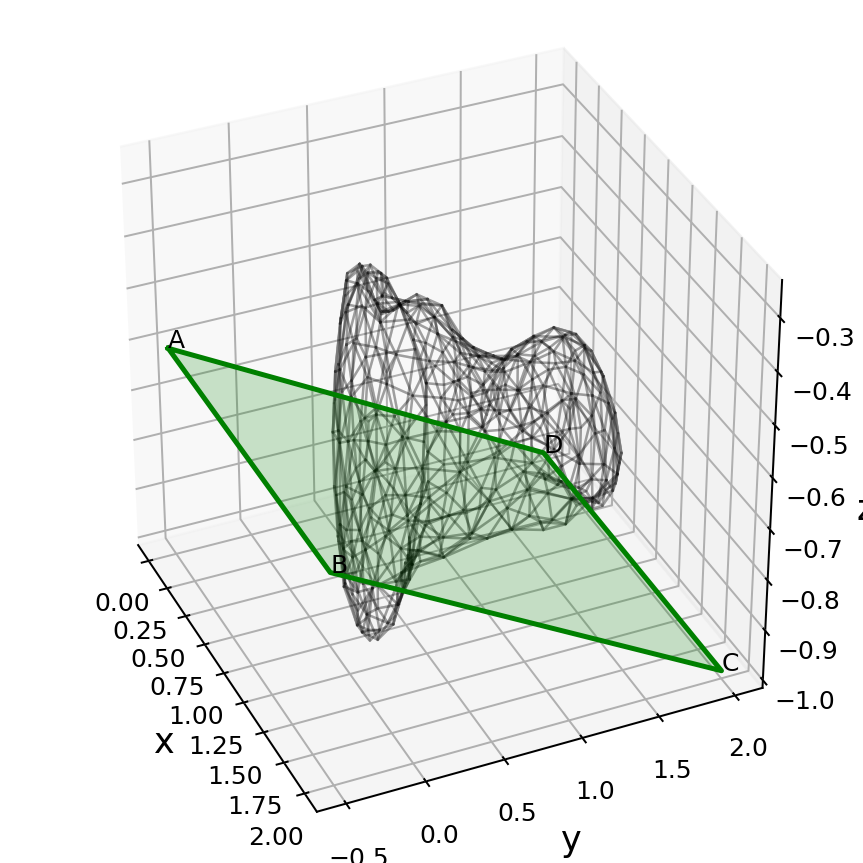

In [4]:
graph_init()
plt.show()

## 平面に接触するポリゴンの描画

In [5]:
## 法線ベクトル
def getVecNormal(v0, v1, v2):
    edge1 = v1 - v0
    edge2 = v2 - v0
    n = np.cross(edge1, edge2)
    return n

## 平面からポリゴンまでの距離
def getLenghtSuf2Poly(a, b, c, d, x1, y1, z1):
    L = (a*x1 + b*y1 + c*z1 + d) / math.sqrt(a**2 + b**2 + c**2)
    return L

In [6]:
## 輪切りする平面の方程式の素材
suf_normal = getVecNormal(surface[0], surface[1], surface[3])
n_a, n_b, n_c = suf_normal
x0, y0, z0 = surface[0]
n_d = -1*(n_a*x0 + n_b*y0 + n_c*z0)

<IPython.core.display.Javascript object>


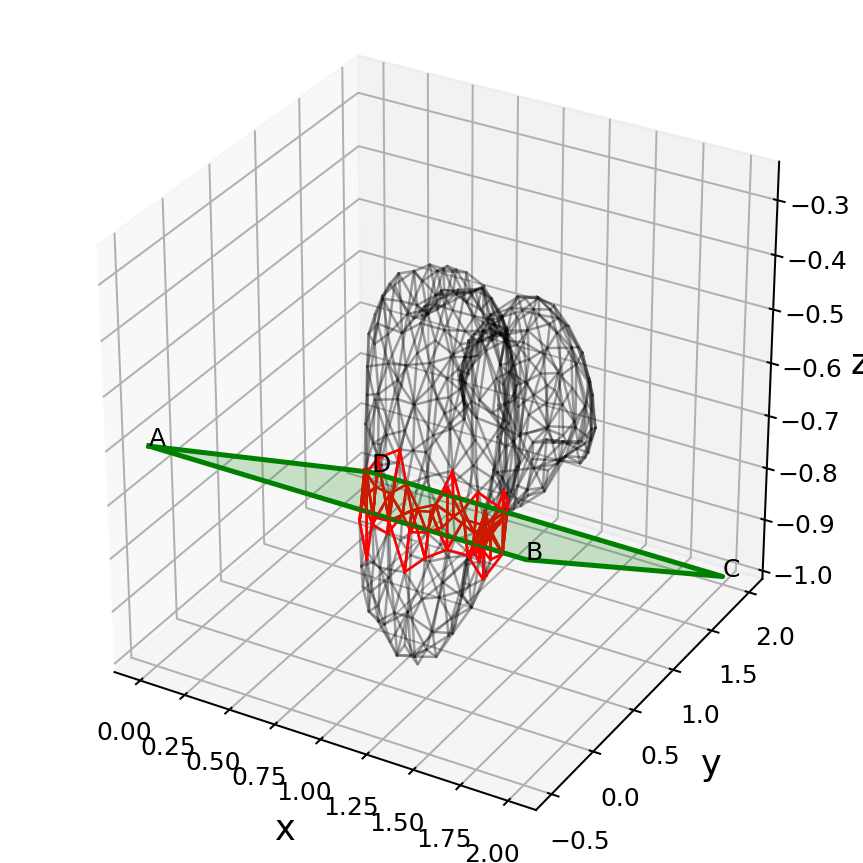

In [7]:
graph_init()
# 平面とモデルの接触点の計算
for polygon in distal_Phalanxh3.stl_instance.getMesh():
    p0, p1, p2 = polygon
    l0 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p0)
    l1 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p1)
    l2 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p2)
    if (l0>0 and l1>0 and l2>0) or (l0<0 and l1<0 and l2<0):
        pass
    else:
        plt.plot(*zip(p0, p1, p2, p0), 'red', lw=1, alpha=1.)
plt.show()

In [8]:
def getMediatingVariable(a, b, c, d, p1, p2):
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    upper    = a*x1 + b*y1 + c*z1 + d
    downer = a*(x1 - x2) + b*(y1 - y2) + c*(z1 - z2)
    u = upper / downer
    return u

<IPython.core.display.Javascript object>


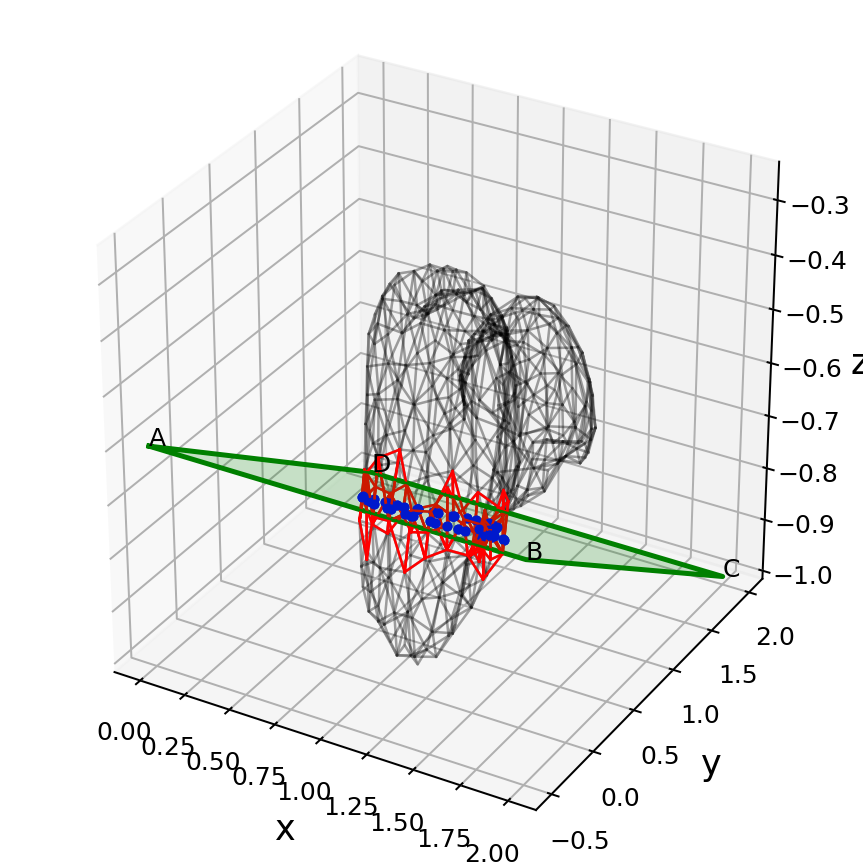

In [10]:
def plotContactPoint(u, p0, p1):
    if 0<=u and u<=1:
        contact_point = p0 + u*(p1-p0)
        #contact_point = np.array(contact_point, dtype=np.uint8)
        plt.plot(*zip(contact_point.tolist()), ".", color="blue")

graph_init()
# 平面とモデルの接触点の計算
distal_mesh = distal_Phalanxh3.stl_instance.getMesh()
for polygon in distal_mesh:
    p0, p1, p2 = polygon
    l0 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p0)
    l1 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p1)
    l2 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p2)
    if (l0>0 and l1>0 and l2>0) or (l0<0 and l1<0 and l2<0):
        pass
    else:
        plt.plot(*zip(p0, p1, p2, p0), 'red', lw=1, alpha=1.)
        
        u0 = getMediatingVariable(n_a, n_b, n_c, n_d, p0, p1)
        u1 = getMediatingVariable(n_a, n_b, n_c, n_d, p1, p2)
        u2 = getMediatingVariable(n_a, n_b, n_c, n_d, p2, p0)
        plotContactPoint(u0, p0, p1)
        plotContactPoint(u1, p1, p2)
        plotContactPoint(u2, p2, p0)
        
plt.show()

In [11]:
def getContactPoint(u, p0, p1):
    if 0<=u and u<=1:
        cp = p0 + u*(p1-p0)
        return cp

def getPolygonContactPoints(a, b, c, d, polygon):
    p0, p1, p2 = polygon
    u0 = getMediatingVariable(a, b, c, d, p0, p1)
    u1 = getMediatingVariable(a, b, c, d, p1, p2)
    u2 = getMediatingVariable(a, b, c, d, p2, p0)
    
    cp0 = getContactPoint(u0, p0, p1)
    cp1 = getContactPoint(u1, p1, p2)
    cp2 = getContactPoint(u2, p2, p0)
    
    cp_list = []
    for cp in (cp0, cp1, cp2):
        if cp is None:
            pass
        else:
            cp_list.append(cp)
    
    cp_lenth = len(cp_list)
    if cp_lenth == 1:
        print("contact point is in contact with a surface")
        
    return cp_list

<IPython.core.display.Javascript object>


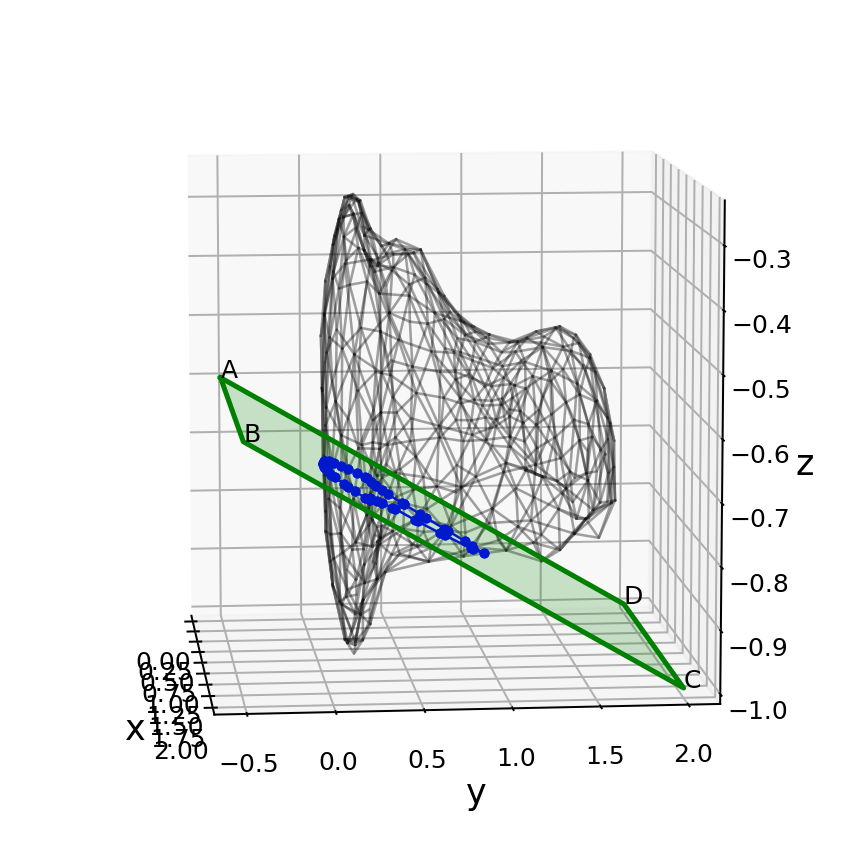

In [12]:
graph_init()
# 平面とモデルの接触点の計算
distal_mesh = distal_Phalanxh3.stl_instance.getMesh()
for polygon in distal_mesh:
    p0, p1, p2 = polygon
    l0 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p0)
    l1 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p1)
    l2 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p2)
    if (l0>0 and l1>0 and l2>0) or (l0<0 and l1<0 and l2<0):
        pass
    else:
        #plt.plot(*zip(p0, p1, p2, p0), 'red', lw=1, alpha=1.)
        
        cp0, cp1 = getPolygonContactPoints(n_a, n_b, n_c, n_d, polygon)
        
        plt.plot(*zip(cp0), ".", color="blue")
        plt.plot(*zip(cp1), ".", color="blue")
        plt.plot(*zip(cp0, cp1), 'blue', lw=1)
        
plt.show()

In [13]:
## 直行座標->球座標
def rectangular2spherical(rect_x, rect_y, rect_z):
    r         = np.round(np.sqrt(rect_x**2 + rect_y**2 + rect_z**2),5)
    theta = np.round(np.arctan2(rect_y, rect_x), 5)
    rho     = np.round(np.arctan2(np.sqrt(rect_x**2 + rect_y**2), rect_z), 5)
    return r, theta, rho

In [14]:
suf_norm = np.linalg.norm(suf_normal)
suf_UnitVec = suf_normal / suf_norm
uv_na, uv_nb, uv_nc = suf_UnitVec

suf_theta = np.arctan2(sqrt(uv_na**2+uv_nb**2), uv_nc)
suf_rho     = np.arctan2(uv_na, uv_nb)
#suf_theta = np.degrees(suf_theta)
#suf_rho     = np.degrees(suf_rho)
print(suf_theta, suf_rho)

0.15865526218640144 -0.0


In [15]:
_, suf_rho, suf_theta = rectangular2spherical(*suf_UnitVec)
print(np.degrees(suf_rho), np.degrees(suf_theta))

90.00021045914971 9.090548377545641


In [16]:
def getXYInversedArray(r, theta, rho):
    rot_x = np.array([[1, 0, 0],
                                [0, np.cos(theta), np.sin(theta)],
                                [0, -np.sin(theta), np.cos(theta)]])
    
    rot_y = np.array([[np.cos(rho), 0, -np.sin(rho)],
                                [0, 1, 0],
                                [np.sin(rho), 0, np.cos(rho)]])
    
    rot_z = np.array([[np.cos(r), np.sin(r), 0],
                                [-np.sin(r), np.cos(r), 0],
                                [0, 0, 1]])
    
    rot_xyz = np.dot(rot_z, np.dot(rot_y, rot_x))
    return (rot_xyz)

<IPython.core.display.Javascript object>


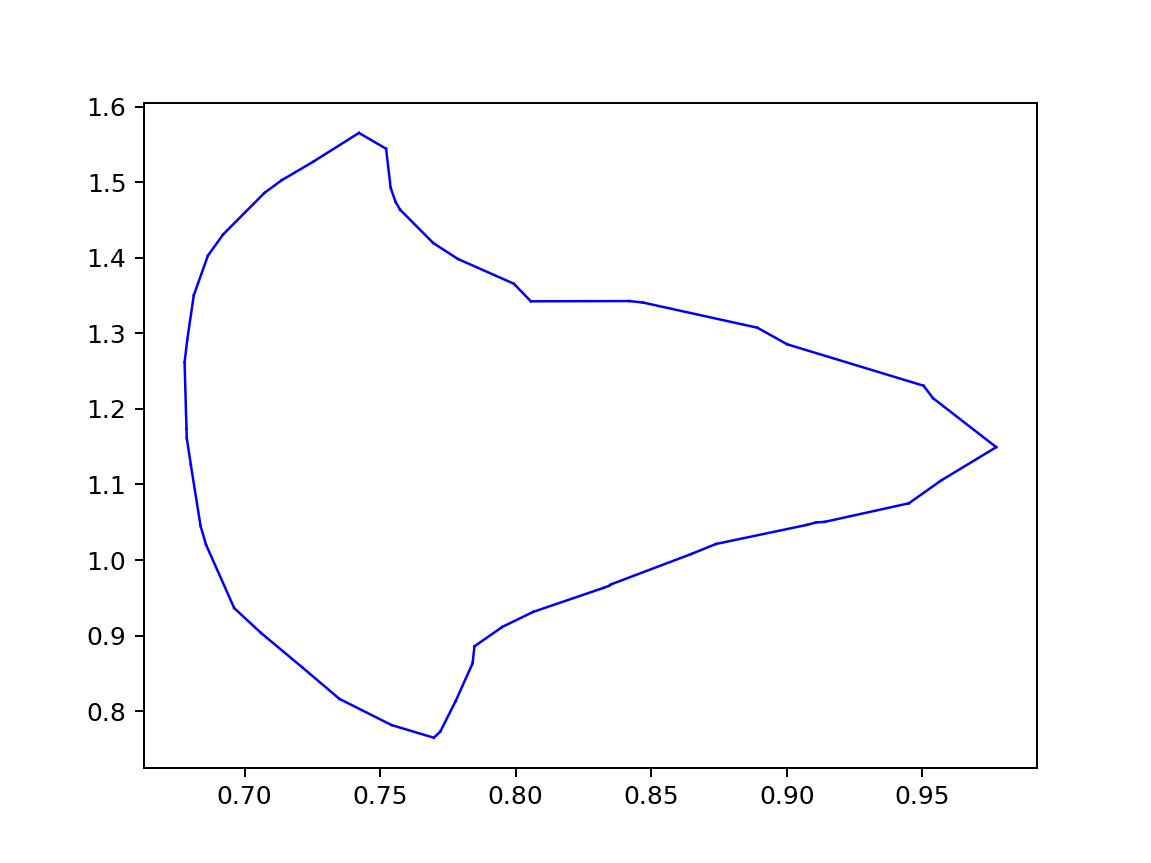

In [17]:
# 平面とモデルの接触点の計算
sliced_coordination = []
fig = plt.figure()

rot_vec = getXYInversedArray(0, suf_theta, suf_rho)
distal_mesh = distal_Phalanxh3.stl_instance.getMesh()
for polygon in distal_mesh:
    p0, p1, p2 = polygon
    l0 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p0)
    l1 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p1)
    l2 = getLenghtSuf2Poly(n_a, n_b, n_c, n_d, *p2)
    if (l0>0 and l1>0 and l2>0) or (l0<0 and l1<0 and l2<0):
        pass
    else:
        cp0, cp1 = getPolygonContactPoints(n_a, n_b, n_c, n_d, polygon)
        suf_cp0 = np.round(np.dot(rot_vec, cp0).reshape(3, 1), 4)[[0, 2], 0]
        suf_cp1 = np.round(np.dot(rot_vec, cp1).reshape(3, 1), 4)[[0, 2], 0]
        
        plt.plot(*zip(suf_cp0, suf_cp1), 'blue', lw=1)
        
        sliced_coordination.append(suf_cp0.tolist())
        sliced_coordination.append(suf_cp1.tolist())
plt.show()

<IPython.core.display.Javascript object>


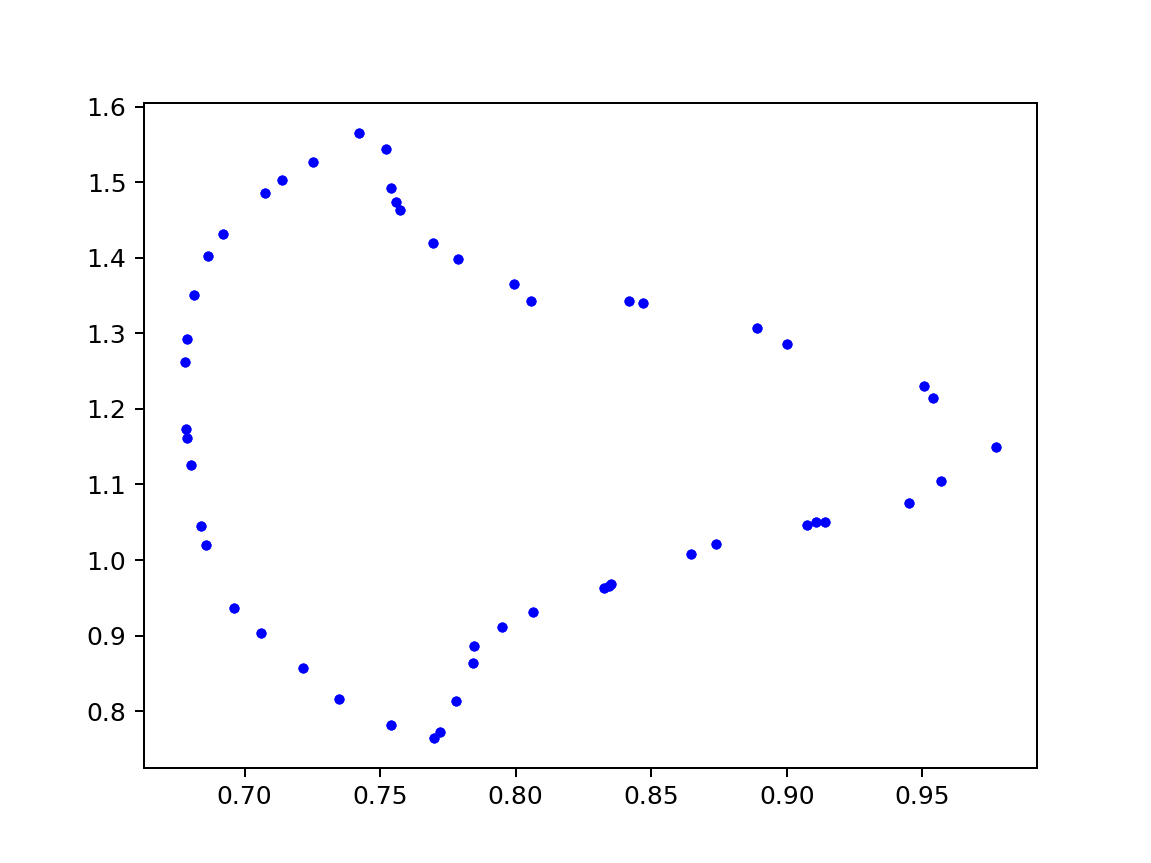

In [18]:
x = np.array(sliced_coordination)[:,0]
y = np.array(sliced_coordination)[:,1]

fig = plt.figure()
plt.plot(x, y, ".", color="blue")
plt.show()